In [1]:
import glob
import os
import datetime as dt

import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio


from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
import statsmodels.api as sm
from scipy import stats as stats
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

This notebook will begin to explore the frequency of large wintertime blowing snow events by first comparing wind speeds between observations (snodgrass site, billy barr site, CO127 site) and models (NLDAS2 and gridMET). We will also use observations of precipitation and temperature to try to index when blowing snow conditions exist (Blowing snow days) similar to analysis from Hoover et al. (2014) who compared observations to reanalysis output from NARR.

### About modeled data:
1. gridMET is a dataset of high-spatial resolution (around 4 km) for daily meteorological data for the United States ([information found here](https://www.climatologylab.org/gridmet.html)). gridMET combines attributes from gridded climate data (PRISM) and regional reanalysis (NLDAS-2) using climatologically aided interpolation which results

**Limitations:**
- will not resolve fine-scale meteorological conditions finer than native resolution (cold pools, precipitation enhancement, gap winds)
- gridMET wind fields and solar radiation are interpolated from NARR/NLDAS-2 which has a 32-km resolution, meaning this data is insufficient to capture mesoscale influences of terrain on winds.
- solar radiation is provided for a planar surface, no terrain adjustments are made.
- "day" is considered midnight-to-midnight.
2. NLDAS-2 (North American Land Data Assimilation System): integrates model reanalysis and observation based data to produce long-term hourly atmospheric forcing data to drive offline land-surface and hydrology models ([information found here](https://climatedataguide.ucar.edu/climate-data/nldas-north-american-land-data-assimilation-system)). NLDAS spans North America at a 1/8 degree grid-spacing. NLDAS-2 is considered the least "pure" as it integrates both reanalysis and station data, rather than being strictly interpolation based. Non-precipitation land-surface forcing is derived from NARR. U and V components of wind are provided. Vertical adjustments using traditional lapse rate of 6.5 K/km for air temperature is used when adjusting differences between NARR and NLDAS fields. Shortwave is bias corrected. Two wind fields are provided. One is a 10-meter wind speed but this ir rarely explicit and is normally equal to the wind speed of the lowest level of the assimilating model (NARR), in this case, that works out to somewhere in the 20-200-m range above the surface. The second product provides the wind fields at a height equal to just above the 

**Limitations:**
- Main limitations seem to stem from issues with resolving precipitation particularly along the US-Canada border
- Changes in behavior of precipitation after 01 January 2012 due to change in the use of precipitation from certain datasets (local to global). Issues seen along coastlines and in the western mountains.
- Warm bias in 2-m surface air temperature

In [2]:
# so NLDAS and gridMET should be very similar, let's see if that is true
# first, let's load in the data
nldas_df = pd.read_csv('./01_data/processed_data/reanalysis_time_series/model_time_series/NLDAS2_wind_speed_time_series.csv', index_col=0, names=['nldas_wind_spd'], skiprows=1)
gridmet_df = pd.read_csv('./01_data/processed_data/reanalysis_time_series/model_time_series/gridMet_wind_speed_time_series.csv', index_col=0, names=['gridmet_wind_spd'], skiprows=1)

# nldas spatial mean
nldas_spatial_df = pd.read_csv('./01_data/processed_data/reanalysis_time_series/model_time_series/NLDAS-2_spatial_mean.csv', index_col=0, names=['nldas_spatial_mean'], skiprows=1)

In [3]:
# let's merge the two dataframes
merged_df = pd.merge(nldas_df, gridmet_df, left_index=True, right_index=True)
merged_df.index = pd.to_datetime(merged_df.index)
# filter to only months between December and March
winter_merged_df = merged_df[(merged_df.index.month >= 12) | (merged_df.index.month <= 4)]

In [4]:
fig = go.Figure()
# add a scatter plot of the two datasets
fig.add_trace(go.Scatter(
    x=merged_df['nldas_wind_spd'],
    y=merged_df['gridmet_wind_spd'],
    mode='markers',
    name='Wind Speed',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.5
    )
))
# add a 1:1 line
fig.add_trace(go.Scatter(
    x=[0, merged_df['nldas_wind_spd'].max()],
    y=[0, merged_df['nldas_wind_spd'].max()],
    mode='lines',
    name='1:1 Line',
    line=dict(
        color='black',
        width=2
    )
))
# udpate the layout with labels and titles and make the figure square
fig.update_layout(
    title='NLDAS vs. GridMET Wind Speed',
    xaxis_title='NLDAS Wind Speed (m/s)',
    yaxis_title='GridMET Wind Speed (m/s)',
    width=600,
    height=600
)
# updat the hover to have the index date
fig.update_traces(hoverinfo='text+x+y', hovertext=merged_df.index)



In [5]:
# let's make a violin plot of wind speed for each month
fig = px.violin(merged_df, x=merged_df.index.month, y=['nldas_wind_spd'], box=True, points='all', title='NLDAS Wind Speed by Month')
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Wind Speed (m/s)'
)
# update the xticks to be month names
fig.update_xaxes(
    tickvals=np.arange(1, 13),
    ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
fig

Okay NLDAS-2 seems a bit more reliable. March and April appear to be the windiest

In [6]:
# Let's see just the occurence of days with greater than 5 m/s wind speed
high_wind_days = merged_df[(merged_df['nldas_wind_spd'] > 5)]
# let's make a violin plot of wind speed for each month
fig = px.violin(high_wind_days, x=high_wind_days.index.month, y=['nldas_wind_spd'], box=True, points='all', title='NLDAS Wind Speed >5 m/s by Month')
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Wind Speed (m/s)'
)
# update the xticks to be month names
fig.update_xaxes(
    tickvals=np.arange(1, 13),
    ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
fig

In [7]:
def create_tidy_mesowest_df(df, station_id, station_units, filter_to_winter=True):
    # create a tidy dataframe
    tidy_df = df.melt(id_vars=['Date_Time'], var_name='variable', value_name='value')
    # map the units to the variables
    tidy_df['unit'] = tidy_df['variable'].map(station_units[station_id].to_dict())
    # convert types to float 
    tidy_df[~((tidy_df['unit'].isna()) | (tidy_df['unit']=='code'))] = tidy_df[~((tidy_df['unit'].isna()) | (tidy_df['unit']=='code'))].apply(pd.to_numeric, errors='ignore')
    # convert Date_Time to datetime
    tidy_df['Date_Time'] = pd.to_datetime(tidy_df['Date_Time'])
    # if station id is equal to CACB1
    if station_id == 'CACB1':
        # convert rotate the wind_direction_set_1 to be in the correct orientation by sutracting pi/2
        tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] = tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] + 90
        # if value is greater than 360 subtract 360
        tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'] = tidy_df.loc[tidy_df['variable'] == 'wind_direction_set_1', 'value'].apply(lambda x: x - 360 if x > 360 else x)
    # set to index
    tidy_df = tidy_df.set_index('Date_Time')
    # convert to datetime
    tidy_df.index = pd.to_datetime(tidy_df.index)
    # filter to only data during cold season months (11,12, 1, 2,3,4)
    if filter_to_winter:
        tidy_df = tidy_df[tidy_df.index.month.isin([11,12,1,2,3,4])]
    return tidy_df

def read_mesowest_data(filepath):
    if 'mesowest' in filepath:
        
        df = pd.read_csv(filepath, comment='#')
        station_id = df['Station_ID'].loc[1]
        station_units = {}
        station_units[station_id] = df.loc[0]
        # drop first row of the dataset and reindex
        df = df.drop(0).reset_index(drop=True)
        # create a tidy dataframe
        tidy_df = create_tidy_mesowest_df(df, station_id, station_units)
        # print the length of the dataset in years
        print(f"{station_id} has {len(tidy_df.index.unique().year.unique())} years of data")
        return tidy_df, station_id
    else:
        print('Not a mesowest file')
        return

def read_sntl_data(filepath, filter_to_winter=True):
    if 'sntl' in filepath:
        df = pd.read_csv(filepath)
        if len(df.query("variable == 'Wind Speed Average (mph)'").value.dropna()) ==0:
            print('No wind data at this site')
            return
        else:
            site_id = filepath.split('/')[-1].split('_')[1]
            # rename Date column to Date_Time
            df = df.rename(columns={'Date':'Date_Time'})
            # set Date_Time to index
            df = df.set_index('Date_Time')
            # convert Date_Time to datetime 
            df.index = pd.to_datetime(df.index)
            # filter to only data during cold season months (11,12, 1, 2,3,4)
            if filter_to_winter:
                df = df[df.index.month.isin([11,12,1,2,3,4])]
            # convert wind speed to m/s from mph
            df.loc[df['variable'] == 'Wind Speed Average (mph)', 'value'] = df.loc[df['variable'] == 'Wind Speed Average (mph)', 'value']*0.44704
            # rename the wind speed variable to change the unit
            df.loc[df['variable'] == 'Wind Speed Average (mph)', 'variable'] = 'Wind Speed Average (m/s)'
        
            # print the length of the dataset in years
            print(f"{site_id}:CO:SNTL has {len(df.index.unique().year.unique())} years of data")
            return df
    else:
        print('Not a sntl file')
        return
    
def get_windy_days(df, wind_speed_var, threshold):
    # get days with wind speed greater than 5 m/s
    mean_wind_speed = df.query(f'variable == "{wind_speed_var}"')['value'].resample('1D').mean()
    # get days with wind speed in the 90th percentile
    # days = mean_wind_speed[mean_wind_speed > mean_wind_speed.quantile(.95)].index
    days = mean_wind_speed[mean_wind_speed > threshold].index
    # filter out days not in months 12,1,2,3,4
    days = days[(days.month >= 12) | (days.month <= 4)]
    print(f"Number of days with wind speed greater than 5 m/s: {len(days)}")
    print(f"Original length: {len(df)}")
    windy_tidy_df = df[pd.to_datetime(df.index.date).isin(days.date)]
    print(f"Filtered length: {len(windy_tidy_df)}")
    return windy_tidy_df

In [8]:
# okay, now lets pull in the observed data
crested_butte_wind = './01_data/raw_data/station_data/long_term_data/mesowest/CO127.2024-04-09.csv'
df, site_id = read_mesowest_data(crested_butte_wind)
wind_speed_var = 'wind_speed_set_1'
wind_dir_var = 'wind_direction_set_1'

/tmp/ipykernel_9188/673450550.py:28: DtypeWarning:

Columns (2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.



CO127 has 10 years of data


In [9]:
co_127_hourly_wind = df.query(f'variable == "{wind_speed_var}"')['value'].resample('1H').mean().to_frame()
co_127_hourly_temp = df.query(f'variable == "air_temp_set_1"')['value'].resample('1H').mean().to_frame()
co_127_hourly_wind.loc[(co_127_hourly_wind['value'] >= 3.7) & (co_127_hourly_temp['value']<=0),"high_wind"] = 1
co_127_hourly_wind.loc[(co_127_hourly_wind['value'] < 3.7) & (co_127_hourly_temp['value']<=0),"high_wind"] = 0
co_127_daily_wind_count = co_127_hourly_wind.groupby(co_127_hourly_wind.index.date).sum()['high_wind']
co_127_daily_wind_count.index = pd.to_datetime(co_127_daily_wind_count.index)
# filter dates only between december and march
co_127_daily_wind_count = co_127_daily_wind_count[(co_127_daily_wind_count.index.month >= 12) | (co_127_daily_wind_count.index.month <= 4)].to_frame()


co_127_daily_wind = df.query(f'variable == "{wind_speed_var}"')['value'].resample('1D').mean()
co_127_daily_wind.index = pd.to_datetime(co_127_daily_wind.index).date

# now filter by the days above the 90th percentile in wind speed
co_127_high_winds = co_127_daily_wind[co_127_daily_wind >= np.percentile(co_127_daily_wind.dropna(),95)]

<Axes: xlabel='water_year'>

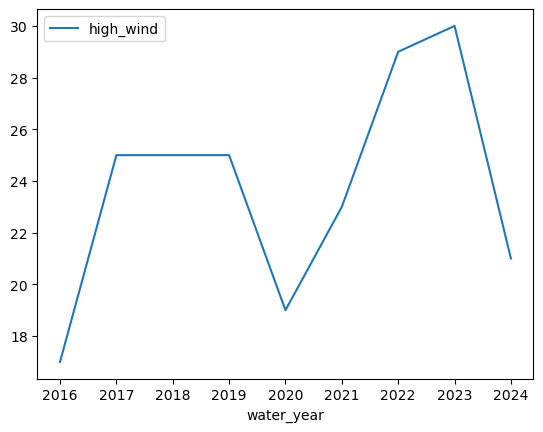

In [10]:
co_127_daily_wind_count['water_year'] = co_127_daily_wind_count.index.year.where(co_127_daily_wind_count.index.month <10, co_127_daily_wind_count.index.year + 1)
# group by water year
co_127_daily_wind_count[co_127_daily_wind_count>3].groupby('water_year').count().plot()


In [11]:
# merge the nldas_wind_speed with co_127_daily_wind
merged_wind = pd.merge(merged_df['nldas_wind_spd'], co_127_daily_wind,left_index=True, right_index=True).dropna()          
# save all values as float      
merged_wind = merged_wind.astype(float)      

In [12]:
# wrf_files = glob.glob('/storage/dlhogan/sos/data/WRF/WY2020/*.nc')
# ds_list = []
# for file in wrf_files:
#     ds_list.append(xr.open_dataset(file))
# # merge the files
# ds = xr.merge(ds_list)

In [13]:
# # calculate wind speed from U and V components
# ds['wspd'] = np.sqrt(ds['U10']**2 + ds['V10']**2)
# # calculate wind direction from U and V components
# ds['wdir'] = np.arctan2(ds['V10'], ds['U10'])*180/np.pi 
# # rotate the wind direction to be from meteorological convention
# ds['wdir'] = ds['wdir'] - 270
# ds['wdir'] = ds['wdir'].where(ds['wdir'] > 0, ds['wdir'] + 360)
# ds['wdir'] = ds['wdir'].where(ds['wdir'] < 360, ds['wdir'] - 360)

In [14]:
# calculate daily mean wind speed
# wrf_daily_mean = ds['wspd'].resample(XTIME='1D').mean()

In [15]:
# get the gamma parameters of the distribution
shape_1, loc_1, scale_1 = stats.gamma.fit(merged_wind['nldas_wind_spd'])
# get the parameters of the distribution
shape_2, loc_2, scale_2 = stats.gamma.fit(merged_wind['value'])

In [16]:
# plot the gamma distribution
fig = go.Figure()
# add a histogram of the data
fig.add_trace(go.Histogram(
    x=merged_wind['nldas_wind_spd'],
    name='NLDAS Wind Speed',
    histnorm='probability'
))
# add a histogram of the data
fig.add_trace(go.Histogram(
    x=merged_wind['value'],
    name='Observed Wind Speed',
    histnorm='probability'
))
# add a gamma distribution
x = np.linspace(0, 15, 100)
y = stats.gamma.pdf(x, shape_1, loc_1, scale_1)/5
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='lines',
    name='Gamma Distribution',
    line=dict(
        color='black',
        width=2
    )
))

# add a gamma distribution
x = np.linspace(0, 15, 100)
y = stats.gamma.pdf(x, shape_2, loc_2, scale_2)/5
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='lines',
    name='Gamma Distribution',
    line=dict(
        color='black',
        width=2
    )
))

In [17]:
# let's make a scatter plot of the two datasets
fig = go.Figure()
# add a scatter plot of the two datasets
fig.add_trace(go.Scatter(
    x=merged_wind['nldas_wind_spd'],
    y=merged_wind['value'],
    mode='markers',
    name='Wind Speed',
    # add regression line
    
))
# add a regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_wind['nldas_wind_spd'], (merged_wind['value']))
print(f"R^2: {r_value**2}")
x = np.linspace(0, 15, 100)
y = slope*x + intercept
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='lines',
    name='Regression Line',
    line=dict(
        color='black',
        width=2
    )
))
# udpate the layout with labels and titles and make the figure square
fig.update_layout(
    title='NLDAS vs. Mesowest Wind Speed',
    xaxis_title='NLDAS Wind Speed (m/s)',
    yaxis_title='Mesowest Wind Speed (m/s)',
    width=600,
    height=600
)
# hover with the date
fig.update_traces(hoverinfo='text+x+y', hovertext=merged_wind.index)

R^2: 0.3328665363764693


In [18]:
# pull in observations from kettle ponds
kettle_ponds_ds = xr.open_dataset('./01_data/raw_data/sos_ds_1day_storage.nc')
kettle_ponds_10m_wind = kettle_ponds_ds['spd_10m_c'].to_dataframe()

In [19]:
# check ERA5 data
era5_wind_speed = pd.read_csv('./01_data/processed_data/reanalysis_time_series/model_time_series/ERA5_wind_speed_time_series.csv', index_col=0, names=['era5_wind_spd'], skiprows=1)
era5_wind_speed.index = pd.to_datetime(era5_wind_speed.index)

In [20]:
# check snograss open site data
snograss_open = pd.read_csv('./01_data/processed_data/east_river_stations/snodgrass_open_site_data_processed.csv', index_col=-1, parse_dates=True)
snograss_open_daily = snograss_open.resample('1D').mean()['max. wind speed']
snograss_open_daily.index = pd.to_datetime(snograss_open_daily.index).date

In [21]:
winter_2023_merged = pd.merge(merged_wind['value'], kettle_ponds_10m_wind, left_index=True, right_index=True).dropna()
winter_2023_merged_model = pd.merge(merged_wind['nldas_wind_spd'], kettle_ponds_10m_wind, left_index=True, right_index=True).dropna()

In [22]:
# calculte mean absolute difference between the two datasets value and spd_10_c for winter_2023_merged
mad = np.mean(np.abs(winter_2023_merged['value'] - winter_2023_merged['spd_10m_c']))
print(mad)
# add the mad to winter_2023_merged_values
winter_2023_merged['value'] = winter_2023_merged['value'] + mad

1.338039665978177


In [23]:
fig = px.scatter(winter_2023_merged, x='value', y='spd_10m_c', trendline='ols')
# plot a 1:1 line
fig.add_trace(go.Scatter(
    x=[0, winter_2023_merged['value'].max()],
    y=[0, winter_2023_merged['value'].max()],
    mode='lines',
    name='1:1 Line',
    line=dict(
        color='black',
        width=2
    )
))
fig.update_layout(
    title='CO127 vs. KP Wind Speed',
    xaxis_title='CO127 Wind Speed (m/s)',
    yaxis_title='KP Wind Speed (m/s)',
    height=600,
    width=600
)

### Pull in SNOTEL Temperature and Precipitation data from Butte

In [24]:
# open Butte snotel data
butte_df = pd.read_csv('./01_data/raw_data/station_data/long_term_data/sntl_tidy/Butte_380_SNTL_tidy.csv')

In [25]:
precip = butte_df.query('variable == "Precipitation Increment (in)"')
# filter out values below zero and above 3
precip = precip[(precip['value'] >= 0) & (precip['value'] <= 3)]
average_temp = butte_df.query('variable == "Air Temperature Average (degF)"')
# filter out values below -50 and above 100
average_temp = average_temp[(average_temp['value'] >= -40) & (average_temp['value'] <= 100)]
# rename the value columns to be equal to the variable name
average_temp = average_temp.rename(columns={'value':average_temp['variable'].iloc[0]})
precip = precip.rename(columns={'value':precip['variable'].iloc[0]})
# average_temp = average_temp[average_temp['qc_flag']=='V']
# for both set index to Date
average_temp = average_temp.set_index('Date')
precip = precip.set_index('Date')
# convert to datetime
average_temp.index = pd.to_datetime(average_temp.index)
precip.index = pd.to_datetime(precip.index)

Filter out days will above zero temperature average and days without precipitation in the current day or the next 4 days

In [26]:
# merge the two datasets
precip_temp_merged = pd.merge(average_temp, precip, left_index=True, right_index=True)
# create a new column where if precip is greater than 0, add 1 for the next 4 days
precip_temp_merged['precip_4_day'] = 0
precip_temp_merged.loc[precip_temp_merged['Precipitation Increment (in)']>0, 'precip_4_day'] = 1
precip_temp_merged.loc[precip_temp_merged['Precipitation Increment (in)'].shift(1)>0, 'precip_4_day'] = 1
precip_temp_merged.loc[precip_temp_merged['Precipitation Increment (in)'].shift(2)>0, 'precip_4_day'] = 1
precip_temp_merged.loc[precip_temp_merged['Precipitation Increment (in)'].shift(3)>0, 'precip_4_day'] = 1
precip_temp_merged.loc[precip_temp_merged['Precipitation Increment (in)'].shift(4)>0, 'precip_4_day'] = 1
# filter to only days with air temperature below 32 and precip greater than 0
precip_temp_merged_filtered = precip_temp_merged[(precip_temp_merged['Air Temperature Average (degF)']<=32) & (precip_temp_merged['precip_4_day']>0)]
print(len(precip_temp_merged))
print(len(precip_temp_merged_filtered))

13687
5036


Grab billy barr's wind observations

In [27]:
bb_wind = pd.read_excel('./01_data/raw_data/aawxwind.xlsx', header=1)
# drop the last column
bb_wind = bb_wind.drop(bb_wind.columns[-1], axis=1)
# use the following dictionary to rename the months
month_dict = {
    'A':9,
    'B':10,
    'C':11,
    'D':12,
    'E':1,
    'F':2,
    'G':3,
    'H':4,
    'I':5,
    'J':6,
    'K':7,
    'L':8
}
# rename the months
bb_wind['month'] = bb_wind['month'].map(month_dict)

# create a new year column using the first and last two digits of the winter column
bb_wind['year'] = bb_wind['winter'].apply(lambda x: int(str(x)[:2] + str(x)[-2:]))
# if month is greater than 10, subtract 1 from the year
# bb_wind.loc[bb_wind['month'] > 10, 'year'] = bb_wind.loc[bb_wind['month'] > 10, 'year'] - 1
# create a datetime column
bb_wind['Date_Time'] = pd.to_datetime(bb_wind[['year', 'month', 'day']])

# filter 
bb_wind_4_filtered = bb_wind[(bb_wind[' wind']==4) | (bb_wind[' wind']==3) & (bb_wind['month'].isin([12,1,2,3,]))]
bb_wind_3_filtered = bb_wind[(bb_wind[' wind']==3) & (bb_wind['month'].isin([12,1,2,3]))]


/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning:

Cannot parse header or footer so it will be ignored



FIlter to windy days using our Blowing Snow Index

In [30]:
windy_bsd_days = precip_temp_merged_filtered.loc[precip_temp_merged_filtered.index.isin(pd.to_datetime(bb_wind_4_filtered['Date_Time'].values))]
windy_bsd_days['water_year'] = windy_bsd_days.index.year.where(windy_bsd_days.index.month <10, windy_bsd_days.index.year + 1)
wind_bsd_day_counts = windy_bsd_days[windy_bsd_days['precip_4_day']>0].groupby('water_year').count()['variable_x']
fig = px.bar(
    wind_bsd_day_counts,
    x=wind_bsd_day_counts.index,
    y='variable_x',

)
fig.update_layout(
    # title='Days with Wind Speed > 5 m/s and Precipitation at BSD',
    xaxis_title='Water Year',
    yaxis_title='Number of Blowing Snow Days',
    height=400,
    width=600,
    # make paper transparent
    paper_bgcolor='rgba(0,0,0,0)',
)
fig.update_xaxes(
    tickvals=wind_bsd_day_counts.index,
    ticktext=wind_bsd_day_counts.index,
    # increase fontsize
    tickfont=dict(size=16),
    titlefont=dict(size=16)
)

fig.update_yaxes(
    # increase fontsize
    tickfont=dict(size=16),
    titlefont=dict(size=16),

)
# save at 300 dpi
pio.write_image(fig, './04_products/figures/sandbox/blowing_snow_days.png', scale=5)

In [151]:
# get accumulated precipitation over each water year
precip_temp_merged['water_year'] = precip_temp_merged.index.year.where(precip_temp_merged.index.month <10, precip_temp_merged.index.year + 1)   
# create pivot table on water year 
precip_pivot = precip_temp_merged.pivot_table(index='water_year', values='Precipitation Increment (in)', aggfunc='cumsum')
precip_pivot['water_year'] = precip_temp_merged['water_year']
# for each water year, create a dataframe with the cumulative precipitation
april_1_precip = {}
for year in precip_pivot['water_year'].unique():
    df = precip_pivot[precip_pivot['water_year'] == year]['Precipitation Increment (in)']
    df.index = pd.to_datetime(df.index)
    df.name = year
    # get the value on april 1
    if dt.datetime(year, 4, 1) in df.index:
        april_1_value = df.loc[dt.datetime(year, 4, 1)]
        april_1_precip[year] = (april_1_value)

In [177]:
fig = px.scatter(
    combined_april1_swe_precip,
    x='april_1_precip',
    y='value',
    trendline='ols'
)
fig.add_trace(go.Scatter(
    x=[5, combined_april1_swe_precip['april_1_precip'].max()],
    y=[5, combined_april1_swe_precip['april_1_precip'].max()],
    mode='lines',
    name='1:1 Line',
    line=dict(
        color='black',
        width=2
    )
))
fig.update_layout(
    title='April 1 SWE vs. Precipitation',
    xaxis_title='April 1 Precipitation (in)',
    yaxis_title='April 1 SWE (in)',
    height=600,
    width=600
)   
# add index to hover
fig.update_traces(hoverinfo='text+x+y', hovertext=combined_april1_swe_precip.index,)

In [27]:
fig = go.Figure()
# create a side by side bar plot for each of the filtered datasets
windy = bb_wind_4_filtered.groupby('year').count()[' wind']
mostly_windy = bb_wind_3_filtered.groupby('year').count()[' wind']

fig.add_trace(go.Bar(
    x=windy.index,
    y=windy,
    name='Windy Days'
))
fig.add_trace(go.Bar(
    x= co_127_daily_wind_count[co_127_daily_wind_count>10].groupby('water_year').count().index,
    y= co_127_daily_wind_count[co_127_daily_wind_count>10].groupby('water_year').count()['high_wind'],
    name='High Wind Days'
))
# fig.add_trace(go.Bar(
#     x=mostly_windy.index,
#     y=mostly_windy,
#     name='Mostly Windy Days'
# ))
fig.update_layout(
    title='High Wind Speed Days in Gothic from billy barr',
    xaxis_title='Year',
    yaxis_title='Number of Days'
)

In [ ]:
winter_2023_merged_model[winter_2023_merged_model['spd_10m_c']>4]

In [127]:
fig = px.scatter(winter_2023_merged_model[winter_2023_merged_model['spd_10m_c']>5], x='nldas_wind_spd', y='spd_10m_c', trendline='ols')
# plot a 1:1 line
fig.add_trace(go.Scatter(
    x=[0, winter_2023_merged_model[winter_2023_merged_model['spd_10m_c']>5]['nldas_wind_spd'].max()],
    y=[0, winter_2023_merged_model[winter_2023_merged_model['spd_10m_c']>5]['nldas_wind_spd'].max()],
    mode='lines',
    name='1:1 Line',
    line=dict(
        color='black',
        width=2
    )
))
fig.update_layout(
    title='NLDAS-2 vs. KP Wind Speed',
    xaxis_title='NLDAS-2 Wind Speed (m/s)',
    yaxis_title='KP Wind Speed (m/s)',
    height=500,
    width=600
)

In [83]:
# open sail_processed data

sail_processed = pd.read_parquet('./01_data/processed_data/sail/gucdlrhiM1.b1/')

In [99]:
radisonde_ds = xr.open_dataset('./01_data/raw_data/sail_high_wind_events/radiosonde/gucsondewnpnM1.b1.20230316.232900.cdf')


In [100]:
radisonde_ds['relative_alt'] = radisonde_ds['alt'] - radisonde_ds['alt'].isel(time=0)

In [101]:
radisonde_df = radisonde_ds.to_dataframe()

In [108]:
filtered_sail_data = sail_processed[(sail_processed['x_offset']==-250) &
                                    (sail_processed['scan_time'].isin(
                                                 [dt.datetime(2023,3,16,15,30,0),
                                                  dt.datetime(2023,3,16,15,33,0),
                                                  dt.datetime(2023,3,16,16,0,0),
                                                  dt.datetime(2023,3,16,16,3,0)]
                                                  ))]

# create a figure
fig = go.Figure()
# add a scatter plot of the two datasets
for time in filtered_sail_data['scan_time'].unique():
    fig.add_trace(go.Scatter(
        x=filtered_sail_data[filtered_sail_data['scan_time'] == time]['streamwise_velocity']['median'],
        y=filtered_sail_data[filtered_sail_data['scan_time'] == time]['z_binned'],
        mode='lines',
        name=time.strftime('%Y-%m-%d %H:%M:%S'),
        line=dict(
            width=4
        ),
    ))
fig.add_trace(go.Scatter(
    x=radisonde_df.where((radisonde_df['relative_alt']>50) & (radisonde_df['relative_alt']<=1000))['arith_wspd'],
        y=radisonde_df.where((radisonde_df['relative_alt']>50) & (radisonde_df['relative_alt']<=1000))['relative_alt'],
        # color by wind direction
        name='Radiosonde',
        mode='markers',
        marker=dict(
            color=radisonde_df.where((radisonde_df['relative_alt']>50) & (radisonde_df['relative_alt']<=1000))['deg'],
            colorscale='twilight_r',
            cmin=0,
            cmax=360,
            showscale=True,
            colorbar={
                    #   "title": "Wind Direction (degrees)",
                      "tickvals": [0, 90, 180, 270, 360],
                      "ticktext": ["N", "E", "S", "W", "N"],
                      "tickfont": {"size": 16}
                      },
        )
))

# plot a vertical dashed line at 0
fig.add_shape(
    dict(
        type='line',
        x0=0,
        x1=0,
        y0=0,
        y1=1000,
        line=dict(
            color='black',
            width=2,
            dash='dash'
        )
    )
)
# filter to 0, to 800 mets
fig.update_yaxes(range=[50, 800])
fig.update_xaxes(range=[-15,15])
# udpate the layout with labels and titles and make the figure square
fig.update_layout(
    # title='SAIL Wind Speed Profile',
    xaxis_title='Wind Speed [Streamwise Velocity] (m/s)',
    yaxis_title='Height Above Ground (m)',
    width=600,
    height=600,
    # increase x and y-tick font size
    xaxis=dict(
        tickfont=dict(
            size=18
        ),
        title_font=dict(
            size=20
        )
    ),
    yaxis=dict(
        tickfont=dict(
            size=18
        ),
        title_font=dict(
            size=20
        )
    )
)
# move the legend to the top and make it 2 columns
fig.update_layout(legend=dict(
    x=0.05,
    y=1.25,
    traceorder='normal',
    orientation='h',
    font=dict(
        family='sans-serif',
        size=18,
        color='black'
    ),
    bgcolor='LightSteelBlue',
    bordercolor='Black',
    borderwidth=2
))

fig